In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.target import FeatureCorrelation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler


In [2]:
train = pd.read_csv('data/train.csv', index_col="ID")


In [3]:
nan_rows = train[train.isna().any(axis=1)]
nan_rows

,measurement_time,target,source_1_temperature,source_2_temperature,source_3_temperature,source_4_temperature,mean_room_temperature,sun_radiation_east,sun_radiation_west,sun_radiation_south,sun_radiation_north,sun_radiation_perpendicular,outside_temperature,wind_speed,wind_direction,clouds
ID,,,,,,,,,,,,,,,,
4689,2024-05-14 09:00:00,38.833334,32.966667,16.050000,16.066667,18.166667,21.681751,790.333333,101.500000,314.266667,105.400000,798.866667,22.98,4.63,120.0,NaN
4690,2024-05-14 10:00:00,51.350000,38.225000,15.933333,16.000000,16.800000,21.790221,691.833333,119.533333,475.833333,120.500000,845.533333,24.47,5.14,120.0,NaN
4691,2024-05-14 11:00:00,53.266666,40.333335,16.100000,15.966667,16.633333,21.769058,522.833333,133.500000,601.266667,132.533333,872.800000,25.42,6.17,130.0,NaN


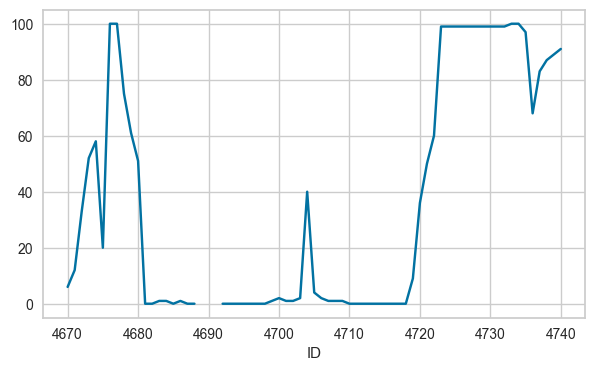

In [4]:
train.loc[4670:4740, "clouds"].plot(figsize=(7, 4))
plt.show()

In [5]:
train['clouds'] = train['clouds'].fillna(0)

In [ ]:
feat_X = train.drop(columns=['target', 'measurement_time'])
feat_y = train['target']

features = np.array(feat_X.columns)
visualizer = FeatureCorrelation(labels=features)

visualizer.fit(feat_X, feat_y)        
visualizer.show()

In [6]:
wv = train['wind_speed']
wd_rad = train['wind_direction']*np.pi / 180

train['Wx'] = wv*np.cos(wd_rad)
train['Wy'] = wv*np.sin(wd_rad)

date_time = pd.to_datetime(train.pop('measurement_time'), format='%Y-%m-%d %H:%M:%S')
date_time_utc = date_time.dt.tz_localize('Europe/Paris', ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

train['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
train['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
train['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
train['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [ ]:
plt.plot(np.array(train['Day sin'])[:25])
plt.plot(np.array(train['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [7]:
test = pd.read_csv("data/test.csv", index_col="ID")

wv = test['wind_speed']
wd_rad = test['wind_direction']*np.pi / 180
test['Wx'] = wv*np.cos(wd_rad)
test['Wy'] = wv*np.sin(wd_rad)

date_time = pd.to_datetime(test.pop('measurement_time'), format='%Y-%m-%d %H:%M:%S')
date_time_utc = date_time.dt.tz_localize('Europe/Paris', ambiguous='NaT', nonexistent='NaT').dt.tz_convert('UTC')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

test['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
test['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
test['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
test['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
test.head()

,source_1_temperature,source_2_temperature,source_3_temperature,source_4_temperature,mean_room_temperature,sun_radiation_east,sun_radiation_west,sun_radiation_south,sun_radiation_north,sun_radiation_perpendicular,outside_temperature,wind_speed,wind_direction,clouds,Wx,Wy,Day sin,Day cos,Year sin,Year cos
ID,,,,,,,,,,,,,,,,,,,,
7047,40.349999,16.625000,16.325000,18.650000,21.171070,114.935484,622.645161,565.741935,115.774194,814.483871,23.43,6.17,200.0,20.0,-5.797903,-2.110264,-0.707107,-7.071068e-01,-0.756908,-0.653521
7048,39.500000,19.333333,17.966667,19.033333,21.464404,97.774194,735.258065,406.677419,99.612903,766.774194,19.10,5.66,210.0,40.0,-4.901704,-2.830000,-0.866025,-5.000000e-01,-0.757376,-0.652978
7049,37.600001,19.566667,18.775000,19.150001,21.561250,76.612903,749.064516,226.290323,81.967742,681.032258,19.23,2.06,230.0,20.0,-1.324142,-1.578052,-0.965926,-2.588190e-01,-0.757844,-0.652435
7050,37.299999,19.350000,19.350000,19.050000,21.498269,52.967742,616.451613,67.612903,70.387097,524.322581,18.83,3.60,220.0,20.0,-2.757760,-2.314035,-1.000000,-1.389210e-11,-0.758312,-0.651892
7051,33.025001,19.066667,19.750000,19.175001,21.417638,25.161290,301.096774,26.838710,88.903226,249.935484,18.12,2.57,220.0,20.0,-1.968734,-1.651964,-0.965926,2.588190e-01,-0.758779,-0.651348


In [8]:
nan_rows = test[test.isna().any(axis=1)]
nan_rows

,source_1_temperature,source_2_temperature,source_3_temperature,source_4_temperature,mean_room_temperature,sun_radiation_east,sun_radiation_west,sun_radiation_south,sun_radiation_north,sun_radiation_perpendicular,outside_temperature,wind_speed,wind_direction,clouds,Wx,Wy,Day sin,Day cos,Year sin,Year cos
ID,,,,,,,,,,,,,,,,,,,,
8281,32.975000,18.799999,19.933333,20.966667,20.000594,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.588190e-01,9.659258e-01,-0.985196,0.171431
8282,31.925000,18.799999,19.975000,23.925000,19.955161,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e-01,8.660254e-01,-0.985073,0.172137
8283,34.849999,18.799999,20.000000,23.200000,19.915765,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,7.071068e-01,7.071068e-01,-0.984949,0.172843
8284,34.524999,18.833333,19.950000,23.825000,19.896111,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,8.660254e-01,5.000000e-01,-0.984825,0.173549
8285,28.924999,18.400000,18.166667,23.966667,19.866835,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,9.659258e-01,2.588190e-01,-0.984701,0.174255
8286,41.066667,22.700000,20.975000,25.025000,20.145493,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,3.520134e-12,-0.984575,0.174961
8287,40.374999,23.100000,21.700000,23.800000,21.125691,36.400000,2.933333,4.533333,3.466667,29.066667,NaN,NaN,NaN,NaN,NaN,NaN,9.659258e-01,-2.588190e-01,-0.984450,0.175667
8288,34.325000,17.100000,16.175000,21.600000,21.392408,309.000000,25.866667,124.400000,26.266667,267.666667,NaN,NaN,NaN,NaN,NaN,NaN,8.660254e-01,-5.000000e-01,-0.984324,0.176372
8289,38.924999,16.433334,16.033333,21.600000,21.609934,550.066667,51.466667,367.733333,51.600000,555.800000,NaN,NaN,NaN,NaN,NaN,NaN,7.071068e-01,-7.071068e-01,-0.984197,0.177078


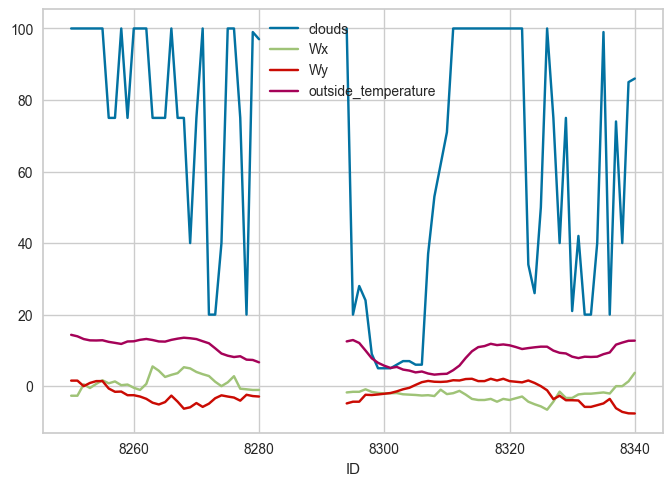

In [9]:
test.loc[8250:8340, ["clouds", 'Wx', 'Wy', 'outside_temperature']].plot()
plt.show()

In [10]:
test.fillna(method='ffill', inplace=True)

C:\Users\trist_243cr5c\AppData\Local\Temp\ipykernel_12440\3181988002.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill', inplace=True)


In [15]:
X = train.drop(columns=['target'])
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [22]:
scaler_train_x = MinMaxScaler()
X_scaled = scaler_train_x.fit_transform(X)

scaler_train_y = MinMaxScaler()
y_scaled = scaler_train_y.fit_transform(y.values.reshape(-1, 1))

In [16]:
#model = GradientBoostingRegressor(loss = 'absolute_error', n_estimators=200, learning_rate=0.1, max_depth=5)
model = RandomForestRegressor(n_estimators=100, max_depth=15, warm_start=True)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, warm_start=True)

In [18]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}")


Mean Absolute Error: 6.19


In [24]:
test_scaled = scaler_train_x.transform(test)

In [13]:
test_predictions = model.predict(test)

In [28]:
print(test_predictions)
unscaled_test_predictions = scaler_train_y.inverse_transform(test_predictions.reshape(-1, 1))
print(unscaled_test_predictions)
   


[0.49283305 0.36597636 0.37949023 ... 0.06422456 0.06304238 0.06373881]
[[30.06950538]
 [22.44964694]
 [23.26137983]
 ...
 [ 4.32442269]
 [ 4.25341286]
 [ 4.29524513]]


In [14]:
sample_submission = pd.read_csv("data/sample_submission.csv", index_col="ID")
test_submission = sample_submission.copy()
test_submission["target"] = test_predictions
test_submission.to_csv("submissions/random_forest/submission27.csv")